In [1]:
import numpy as np 
import pandas as pd
import time
import re
import string
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from wordcloud import WordCloud 
import missingno as msno

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, GridSearchCV
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.ensemble  import RandomForestClassifier

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

In [2]:
train_df = pd.read_csv('../input/wine-variety/Data/train.csv')
test_df = pd.read_csv('../input/wine-variety/Data/test.csv')

The Data Description is as follows:
* user_name - user_name of the reviewer
* country -The country that the wine is from.
* review_title - The title of the wine review, which often contains the vintage.
* review_description - A verbose review of the wine.
* designation - The vineyard within the winery where the grapes that made the wine are from.
* points - ratings given by the user. The ratings are between 0 -100.
* price - The cost for a bottle of the wine
* province - The province or state that the wine is from.
* region_1 - The wine-growing area in a province or state (ie Napa).
* region_2 - Sometimes there are more specific regions specified within a wine-growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank.
* winery - The winery that made the wine
* variety - The type of grapes used to make the wine. Dependent variable for task 2 of the assignment


In [3]:
train_df.head(3)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo


In [4]:
test_df.head(3)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime


# Exploring Dataset

In [5]:
print('======= Train Missing Data =======')
display(train_df.isnull().sum())
print('======= Test Missing Data =======')
display(test_df.isnull().sum())
print('======= Data Types=======')
display(train_df.dtypes)

======= Train Missing Data =======


user_name             19393
country                  35
review_title              0
review_description        0
designation           23647
points                    0
price                  5569
province                 35
region_1              12754
region_2              46708
winery                    0
variety                   0
dtype: int64

======= Test Missing Data =======


user_name              4738
country                   4
review_title              0
review_description        0
designation            5989
points                    0
price                  1394
province                  4
region_1               3314
region_2              11751
winery                    0
dtype: int64

======= Data Types=======


user_name              object
country                object
review_title           object
review_description     object
designation            object
points                  int64
price                 float64
province               object
region_1               object
region_2               object
winery                 object
variety                object
dtype: object

In [6]:
# let's drop unwanted variable
train_df.drop(columns = ['user_name', 'designation', 'region_1', 'region_2'], inplace=True)
test_df.drop(columns = ['user_name', 'designation', 'region_1', 'region_2'], inplace=True)

In [7]:
# seprating the dataset into three categories
train_text = train_df[train_df.columns[1:3]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
test_text = test_df[test_df.columns[1:3]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

# later we can remove or add the feature as per the  requirement
num_features = ['points', 'price']
cat_featues = ['country', 'province', 'winery']
target = ['variety']

In [8]:
# Variable Description of number feature and categorical
print('====== Description of Number Feature ======')
display(train_df[num_features].describe())
print('====== Number of Unique values in Categorical Feature ======')
display(train_df[cat_featues].nunique())

====== Description of Number Feature ======


,points,price
count,82657.000000,77088.000000
mean,88.544564,36.922232
std,3.099649,43.698346
min,80.000000,4.000000
25%,86.000000,18.000000
50%,88.000000,27.000000
75%,91.000000,45.000000
max,100.000000,3300.000000


====== Number of Unique values in Categorical Feature ======


country        38
province      358
winery      13786
dtype: int64

Very interesting distribuition of Points and Price.

* We can see that the values of points are distributed between 80 and 100
* The price have a high difference between the values and a high standard deviation
* In prices, the IQR (Interquantil Range) is 25. The max value is 3300;

We will explore it further later, lets start.

In [9]:
# Imputing missing values
# Train
for i in train_df[num_features].columns:
    train_df[i].fillna(train_df[i].mean(), inplace = True)
    
for i in train_df[cat_featues].columns:
    train_df[i].fillna(train_df[i].mode()[0], inplace = True)

# Test
for i in test_df[num_features].columns:
    test_df[i].fillna(test_df[i].mean(), inplace = True)
    
for i in test_df[cat_featues].columns:
    test_df[i].fillna(test_df[i].mode()[0], inplace = True)

# Exploratory Data Analysis

## Numerical Feature

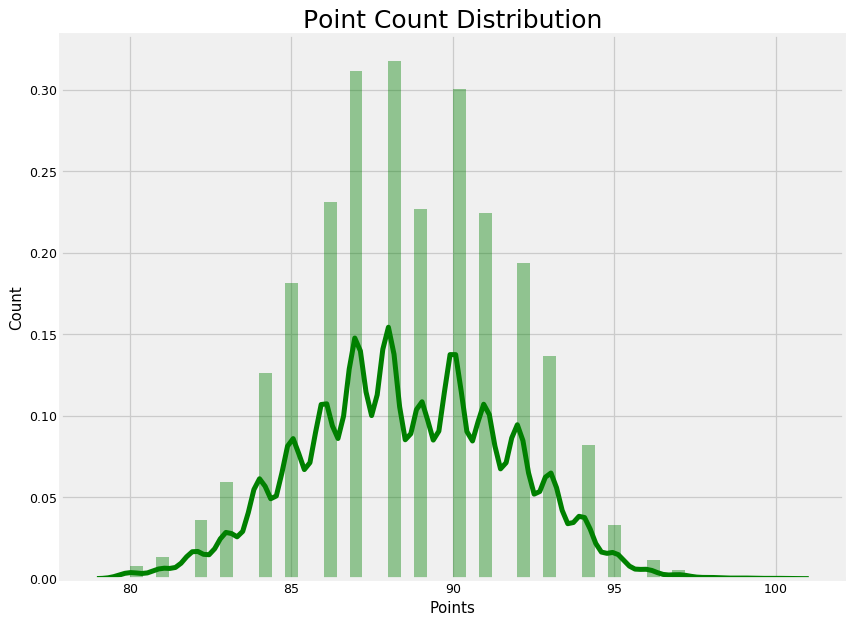

In [10]:
plt.figure(figsize=(10, 8), dpi=90)
g = sns.distplot(train_df.points, bins=50, color='green')
g.set_title('Point Count Distribution', fontsize=20)
g.set_xlabel('Points', fontsize=12)
g.set_ylabel('Count', fontsize=12)
plt.show()

We can clearly see the distribuitioon of the data. It seems very similar with a normal distribution.

Just a few number of wines have less than 82 points and more than 95 points.

As Points are one of the most important metrics in this dataset, I will explore it furthuer more.

I will find for more important informations like quantiles and maybe try to set wines in categories based on it

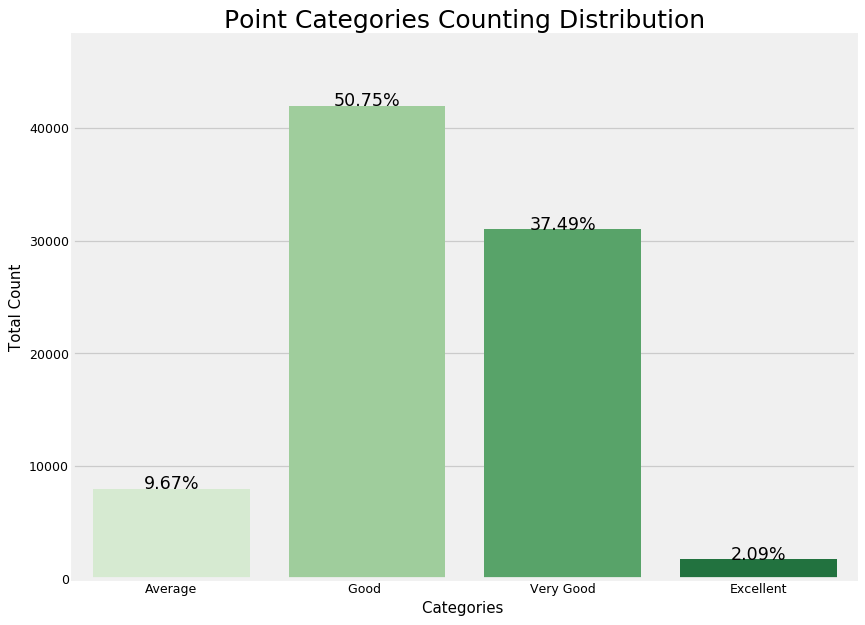

In [11]:
# create a new feature containing the range of the points with a rank to this pontuations
def cat_points(points):
    if points in list(range(80,85)):
        return 'Average'
    elif points in list(range(85,90)):
        return 'Good '
    elif points in list(range(90,95)):
        return 'Very Good'
    else:
        return 'Excellent'

train_df["rating"] = train_df["points"].apply(cat_points)
test_df["rating"] = test_df["points"].apply(cat_points)

# let's add rating feature into categorical feature
cat_featues = ['country', 'province', 'winery', 'rating']


# Ploting Rating categories
total = len(train_df)
plt.figure(figsize=(10, 8), dpi=90)

g = sns.countplot(x='rating', palette='Greens',
                  data=train_df)
g.set_title("Point Categories Counting Distribution", fontsize=20)
g.set_xlabel("Categories ", fontsize=12)
g.set_ylabel("Total Count", fontsize=12)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

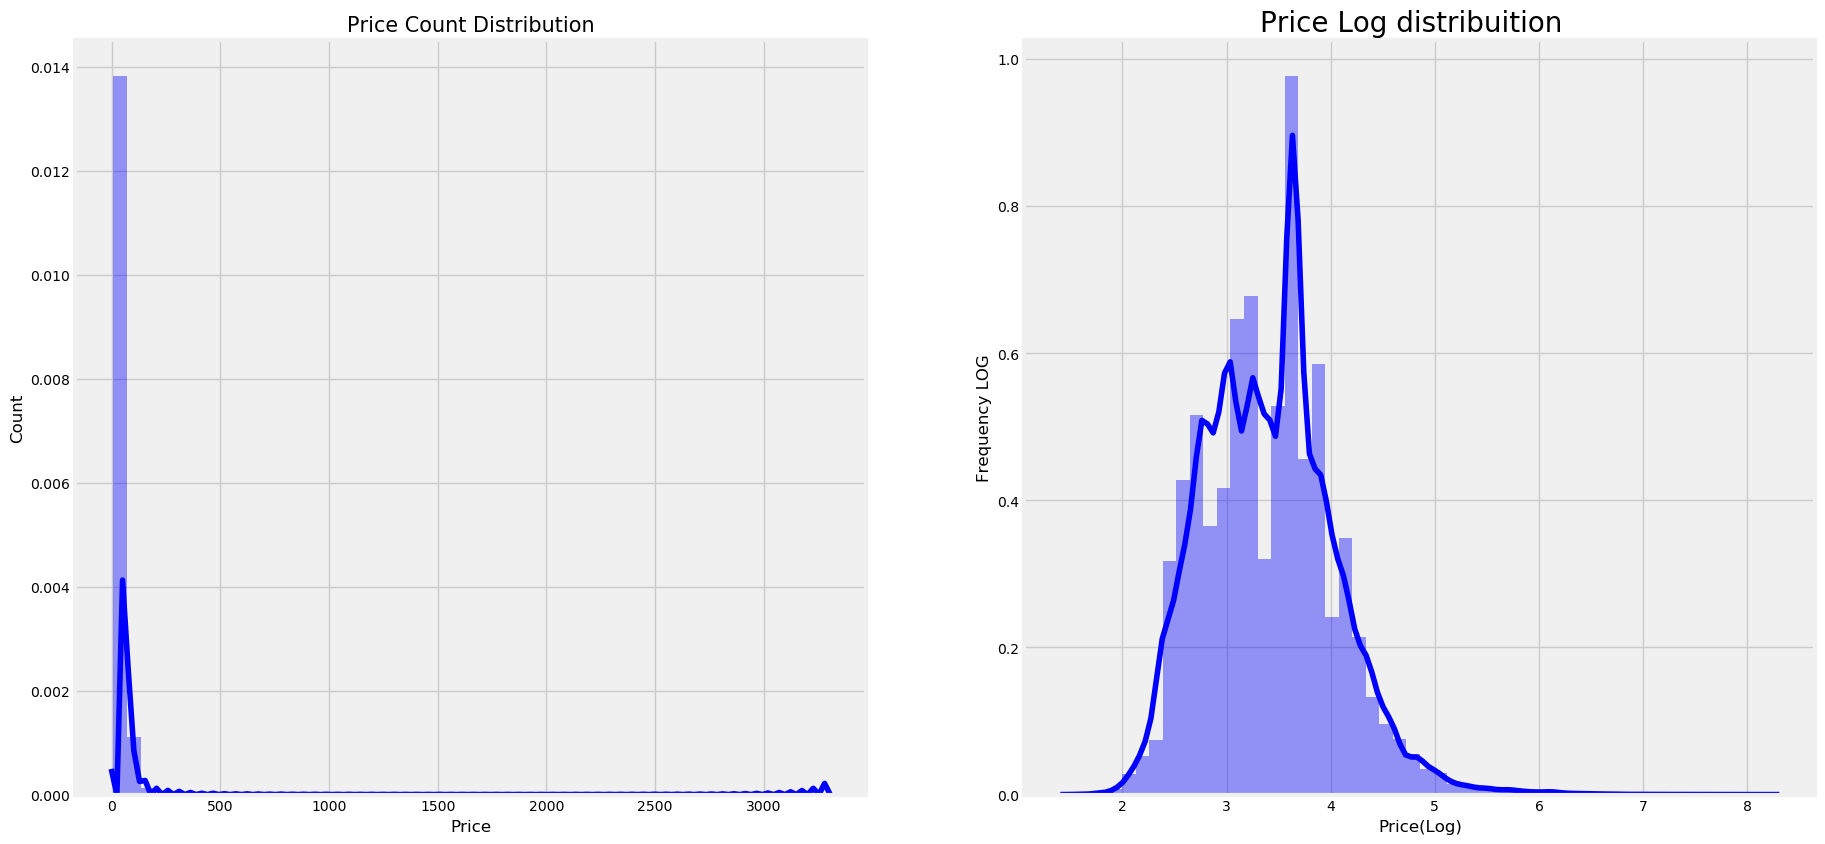

In [12]:
# ploting price distribution
plt.figure(figsize=(20, 10), dpi=100)

g1 = plt.subplot(121)
sns.distplot(train_df.price, bins=50, color='blue')
g1.set_title('Price Count Distribution', fontsize=15)
g1.set_xlabel('Price', fontsize=12)
g1.set_ylabel('Count', fontsize=12)

# Let's get tehe price_log to better work with this feature
train_df['price_log'] = np.log1p(train_df['price'])
test_df['price_log'] = np.log1p(test_df['price'])

# Let's add price log into number feature nad remove point variable
num_features = ['price_log']

g1 = plt.subplot(122)
g1 = sns.distplot(train_df.price_log,
                  color='blue')
g1.set_title("Price Log distribuition  ", fontsize=20)
g1.set_xlabel("Price(Log)", fontsize=12)
g1.set_ylabel("Frequency LOG", fontsize=12)
plt.show()

Nice!!! The Price Log give us an impression that the data could normaly distributed.

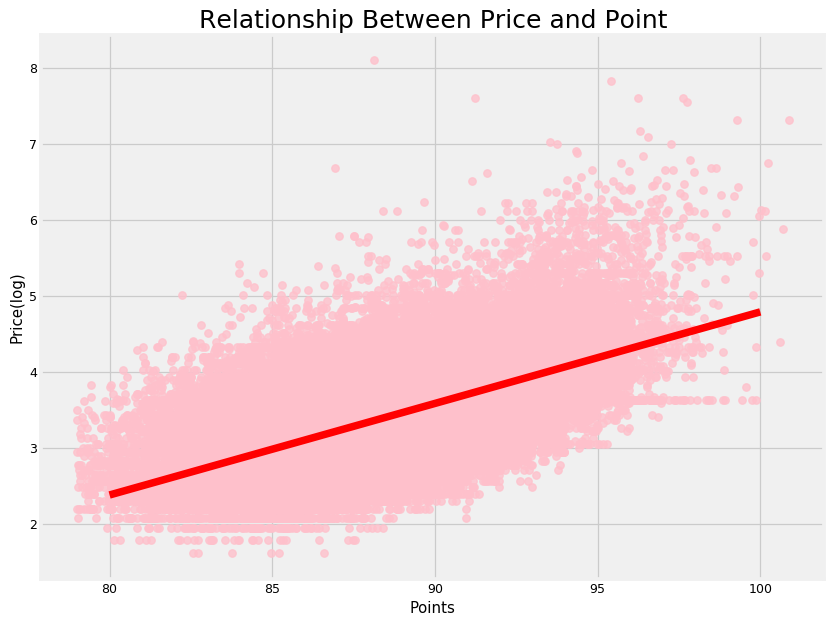

In [13]:
# relationship between price and point

plt.figure(figsize=(10, 8), dpi=90)

g = sns.regplot(x='points', y='price_log', 
                data=train_df, line_kws={'color':'red'},
                x_jitter=True, fit_reg=True, color='pink')
g.set_title("Relationship Between Price and Point", fontsize=20)
g.set_xlabel("Points", fontsize= 12)
g.set_ylabel("Price(log)", fontsize= 12)

plt.show()

Very meaningful scatter plot.

* It shows positive relationship that means as price increases, rating also increase but, 
* The highest prices isn't of the wine with highest rating.
* The most expensive wine have rating between 87 and 90

## Categorical Feature

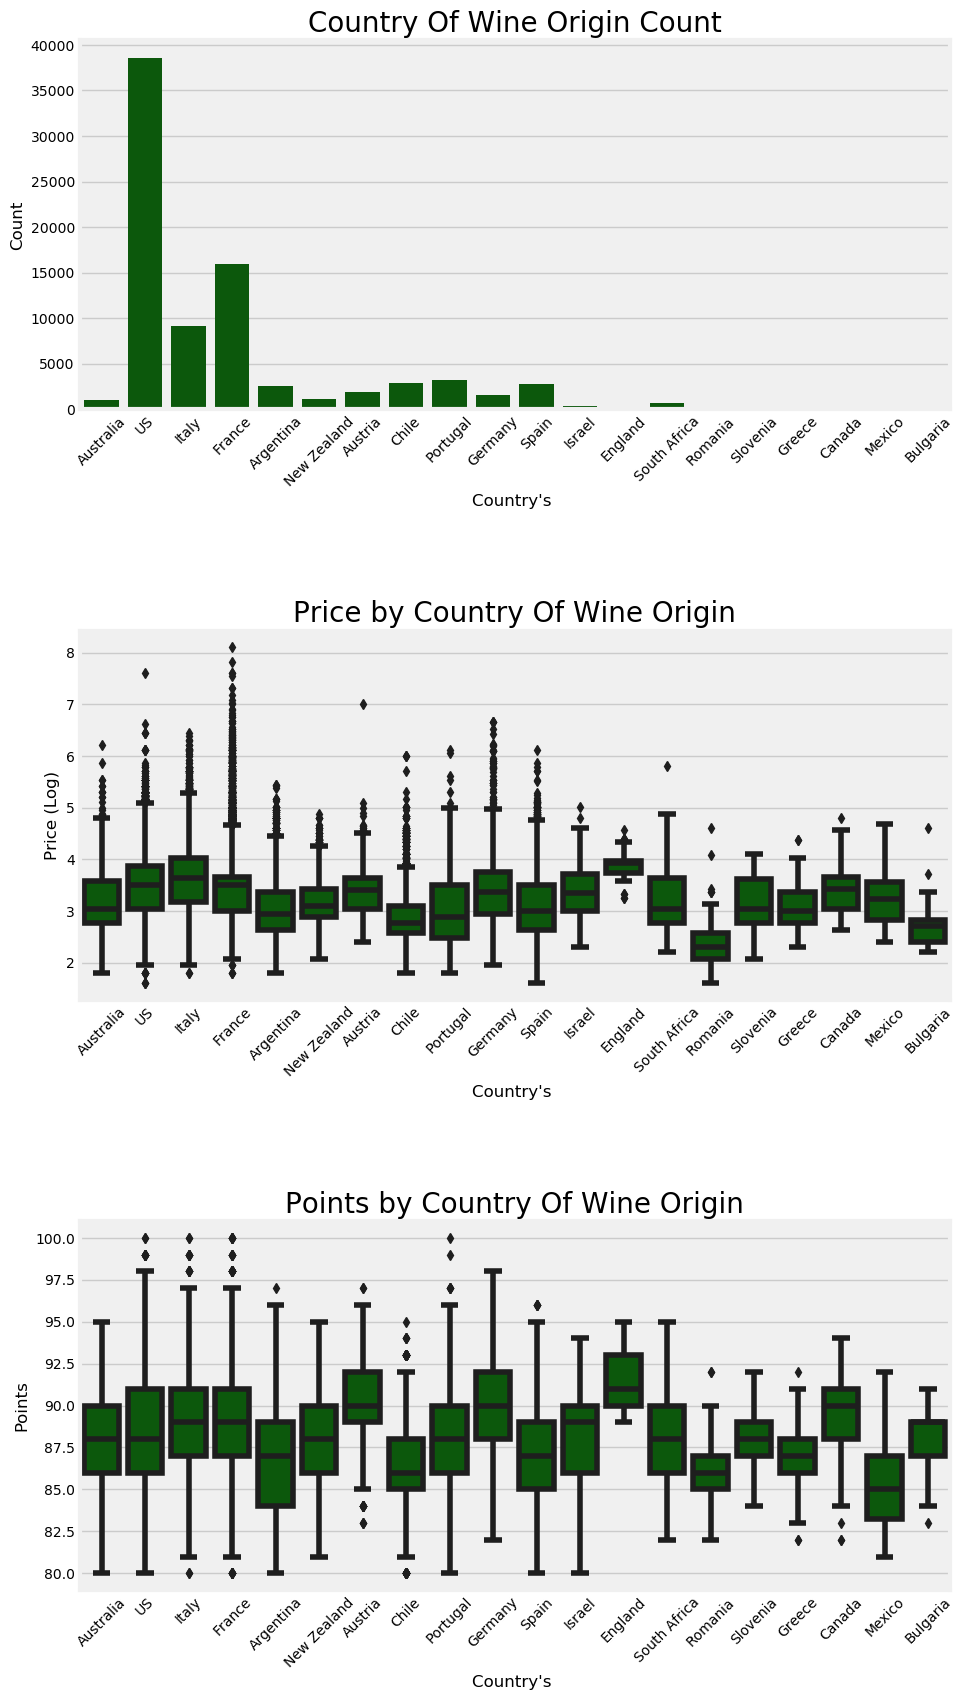

In [14]:
# ploting the distribuition of top 20 countrys by price and rating

country = train_df.country.value_counts()[:20]

plt.figure(figsize=(10, 20), dpi=100)

# Country Of Wine Origin Count
plt.subplot(3,1,1)
g = sns.countplot(x='country', 
                  data=train_df[train_df.country.isin(country.index.values)],
                 color='darkgreen')
g.set_title("Country Of Wine Origin Count", fontsize=20)
g.set_xlabel("Country's ", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

# Price by Country Of Wine Origin
plt.subplot(3,1,2)
g = sns.boxplot(x='country', y='price_log',
                  data=train_df.loc[(train_df.country.isin(country.index.values))],
                 color='darkgreen')
g.set_title("Price by Country Of Wine Origin", fontsize=20)
g.set_xlabel("Country's ", fontsize=12)
g.set_ylabel("Price (Log)", fontsize=12)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

# Points by Country Of Wine Origin
plt.subplot(3,1,3)
g1 = sns.boxplot(x='country', y='points',
                   data=train_df[train_df.country.isin(country.index.values)],
                 color='darkgreen')
g1.set_title("Points by Country Of Wine Origin", fontsize=20)
g1.set_xlabel("Country's ", fontsize=12)
g1.set_ylabel("Points", fontsize=12)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace = 0.6,top = 0.9)

plt.show()

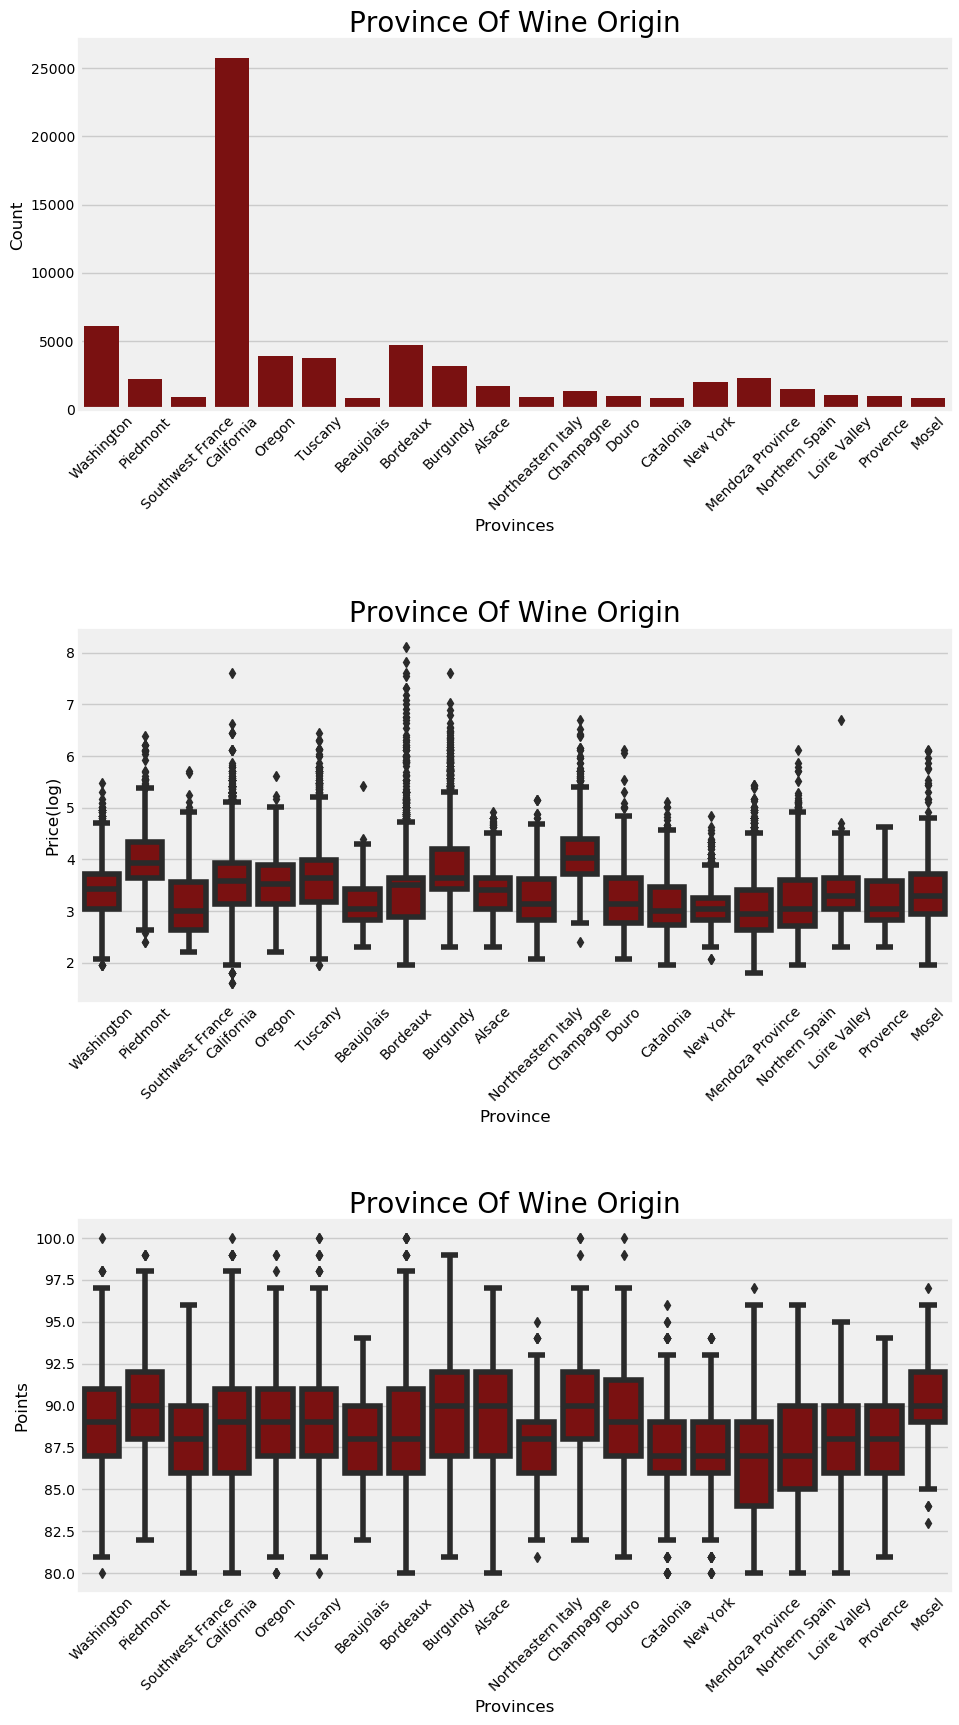

In [15]:

provinces = train_df['province'].value_counts()[:20]

plt.figure(figsize=(10, 20), dpi=100)

plt.subplot(3,1,1)
g = sns.countplot(x='province', 
                  data=train_df.loc[(train_df.province.isin(provinces.index.values))], 
                  color='darkred')
g.set_title("Province Of Wine Origin", fontsize=20)
g.set_xlabel("Provinces", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.subplot(3,1,2)
g1 = sns.boxplot(y='price_log', x='province',
                  data=train_df.loc[(train_df.province.isin(provinces.index.values))], 
                  color='darkred')
g1.set_title("Province Of Wine Origin", fontsize=20)
g1.set_xlabel("Province", fontsize=12)
g1.set_ylabel("Price(log)", fontsize=12)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)

plt.subplot(3,1,3)
g2 = sns.boxplot(y='points', x='province',
                  data=train_df.loc[(train_df.province.isin(provinces.index.values))], 
                  color='darkred')
g2.set_title("Province Of Wine Origin", fontsize=20)
g2.set_xlabel("Provinces", fontsize=12)
g2.set_ylabel("Points", fontsize=12)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace = 0.6,top = 0.9)

plt.show()

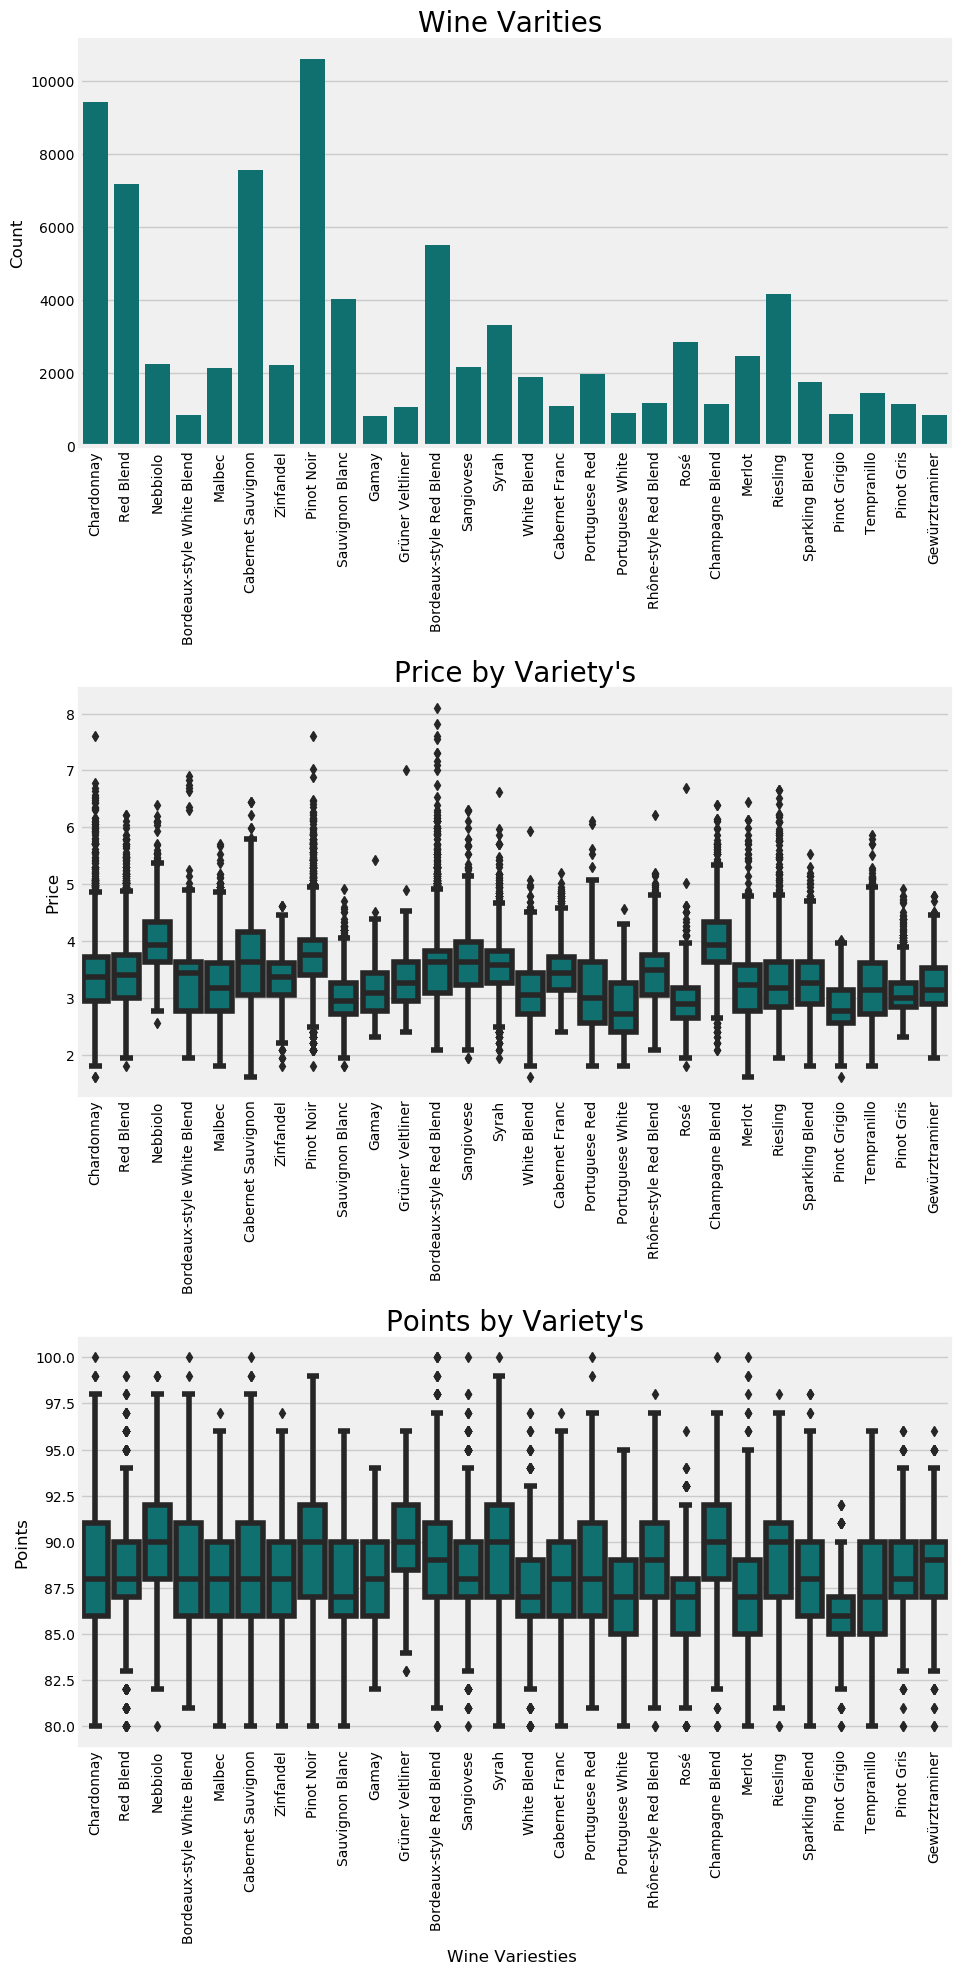

In [16]:
# Distribution of variety or target variable

variety = train_df.variety.value_counts()

plt.figure(figsize=(10, 22), dpi=100)
plt.subplot(3,1,1)
g = sns.countplot(x='variety', 
                  data=train_df.loc[(train_df.variety.isin(variety.index.values))], 
                  color='teal')
g.set_title("Wine Varities ", fontsize=20)
g.set_xlabel(" ", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(3,1,2)
g1 = sns.boxplot(y='price_log', x='variety',
                  data=train_df.loc[(train_df.variety.isin(variety.index.values))], 
                 color='teal')
g1.set_title("Price by Variety's", fontsize=20)
g1.set_xlabel(" ", fontsize=15)
g1.set_ylabel("Price", fontsize=12)
g1.set_xticklabels(g1.get_xticklabels(),rotation=90)

plt.subplot(3,1,3)
g2 = sns.boxplot(y='points', x='variety',
                  data=train_df.loc[(train_df.variety.isin(variety.index.values))], 
                 color='teal')
g2.set_title("Points by Variety's", fontsize=20)
g2.set_xlabel("Wine Variesties ", fontsize=12)
g2.set_ylabel("Points", fontsize=12)
g2.set_xticklabels(g2.get_xticklabels(),rotation=90)

plt.subplots_adjust(hspace = 0.6,top = 0.9)

plt.show()

# Feature Engineering

In [17]:
print('Categorical Feature Are:', cat_featues)
print()
print('Number Feature Are:', num_features)

Categorical Feature Are: ['country', 'province', 'winery', 'rating']

Number Feature Are: ['price_log']


In [18]:
# Lable Encoding High Cardinality Categorical Features
for f in cat_featues:
    if train_df[f].dtype=='object' or test_df[f].dtype=='object':
        lbl = LabelEncoder()
        train_df[f'le_{f}'] = lbl.fit_transform(list(train_df[f].values))
        test_df[f'le_{f}'] = lbl.fit_transform(list(test_df[f].values))
        
# Encode target variable
train_df['le_variety'] = lbl.fit_transform(list(train_df[target].values))

train_df.head(3)

,country,review_title,review_description,points,price,province,winery,variety,rating,price_log,le_country,le_province,le_winery,le_rating,le_variety
0,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",83,10.0,Australia Other,Andrew Peace,Chardonnay,Average,2.397895,1,16,399,0,5
1,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,89,15.0,Washington,North by Northwest,Red Blend,Good,2.772589,35,344,9668,2,17
2,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,94,80.0,Piedmont,Renato Ratti,Nebbiolo,Very Good,4.394449,18,233,10873,3,11


## Text Feature

In [19]:
# review the text
train_text

0        Andrew Peace 2007 Peace Family Vineyard Chardo...
1        North by Northwest 2014 Red (Columbia Valley (...
2        Renato Ratti 2007 Conca  (Barolo),Barolo Conca...
3        Domaine l'Ancienne Cure 2010 L'Abbaye White (B...
4        Château du Cèdre 2012 Le Cèdre Vintage Malbec ...
                               ...                        
82652    Montecillo 2007 Crianza  (Rioja),Hot earth, ba...
82653    Vivác Winery 2008 Single Vineyard Cabernet Sau...
82654    Domaine de la Madone 2014 Nouveau  (Beaujolais...
82655    Château Beaumont 2011  Haut-Médoc,An impressiv...
82656    Round Pond 2010 Estate Cabernet Sauvignon (Rut...
Length: 82657, dtype: object

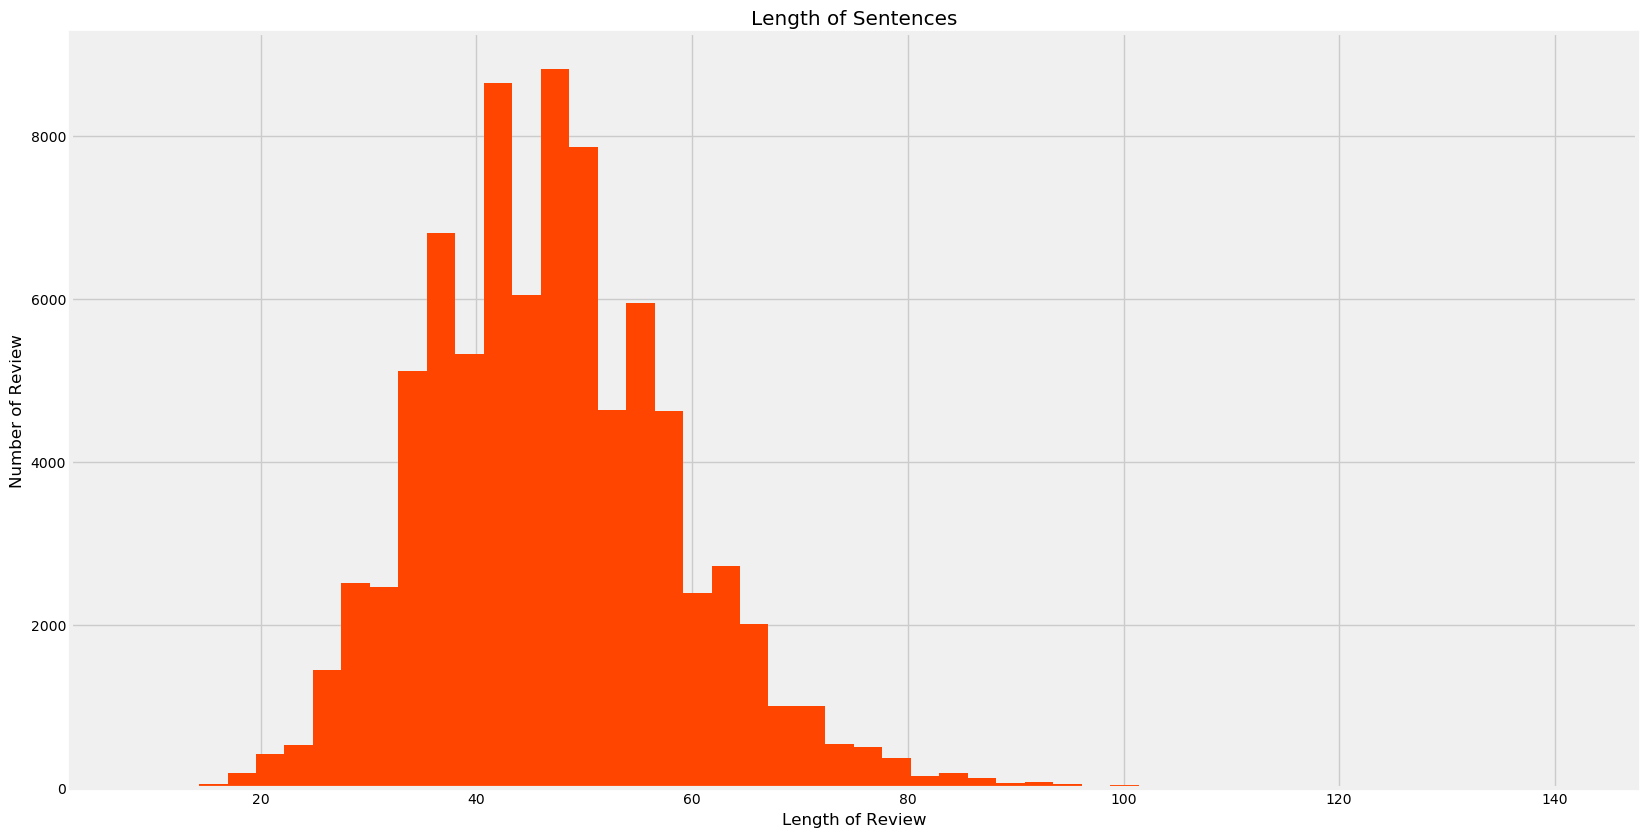

In [20]:
# ploting the lenght of sentences
plt.figure(figsize=(18, 10), dpi=100)
num=train_text.str.split().map(lambda x: len(x))
plt.hist(num,bins = 50,color='orangered')
plt.title('Length of Sentences')
plt.xlabel('Length of Review')
plt.ylabel('Number of Review')
plt.show()

In [21]:
%%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
train_text = train_text.apply(lambda x: clean_text(x))
test_text = test_text.apply(lambda x: clean_text(x))
train_text.head(3)

CPU times: user 12.6 s, sys: 22.1 ms, total: 12.6 s
Wall time: 12.6 s


0    andrew peace  peace family vineyard chardonnay...
1    north by northwest  red columbia valley wathis...
2    renato ratti  conca  barolobarolo conca opens ...
dtype: object

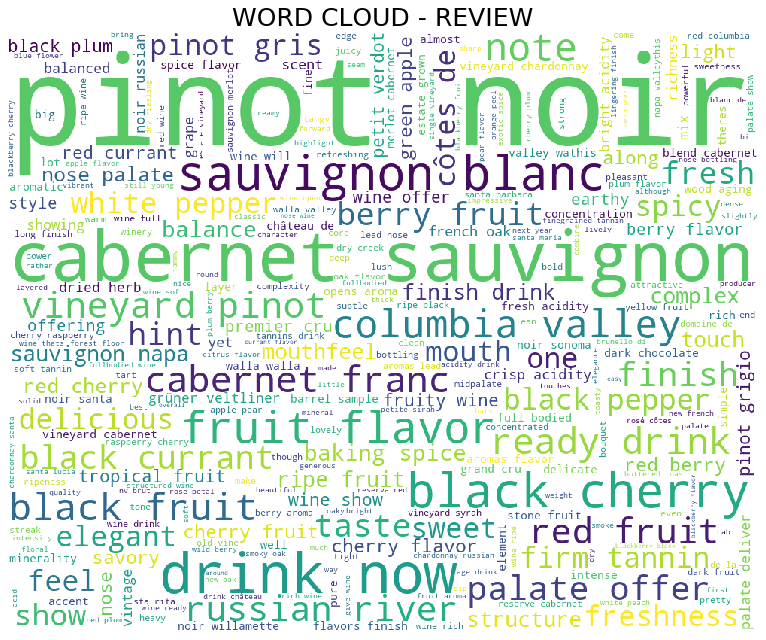

In [22]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(train_text))

fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - REVIEW",fontsize=25)
plt.axis('off')
plt.show()

### N-gram Analysis

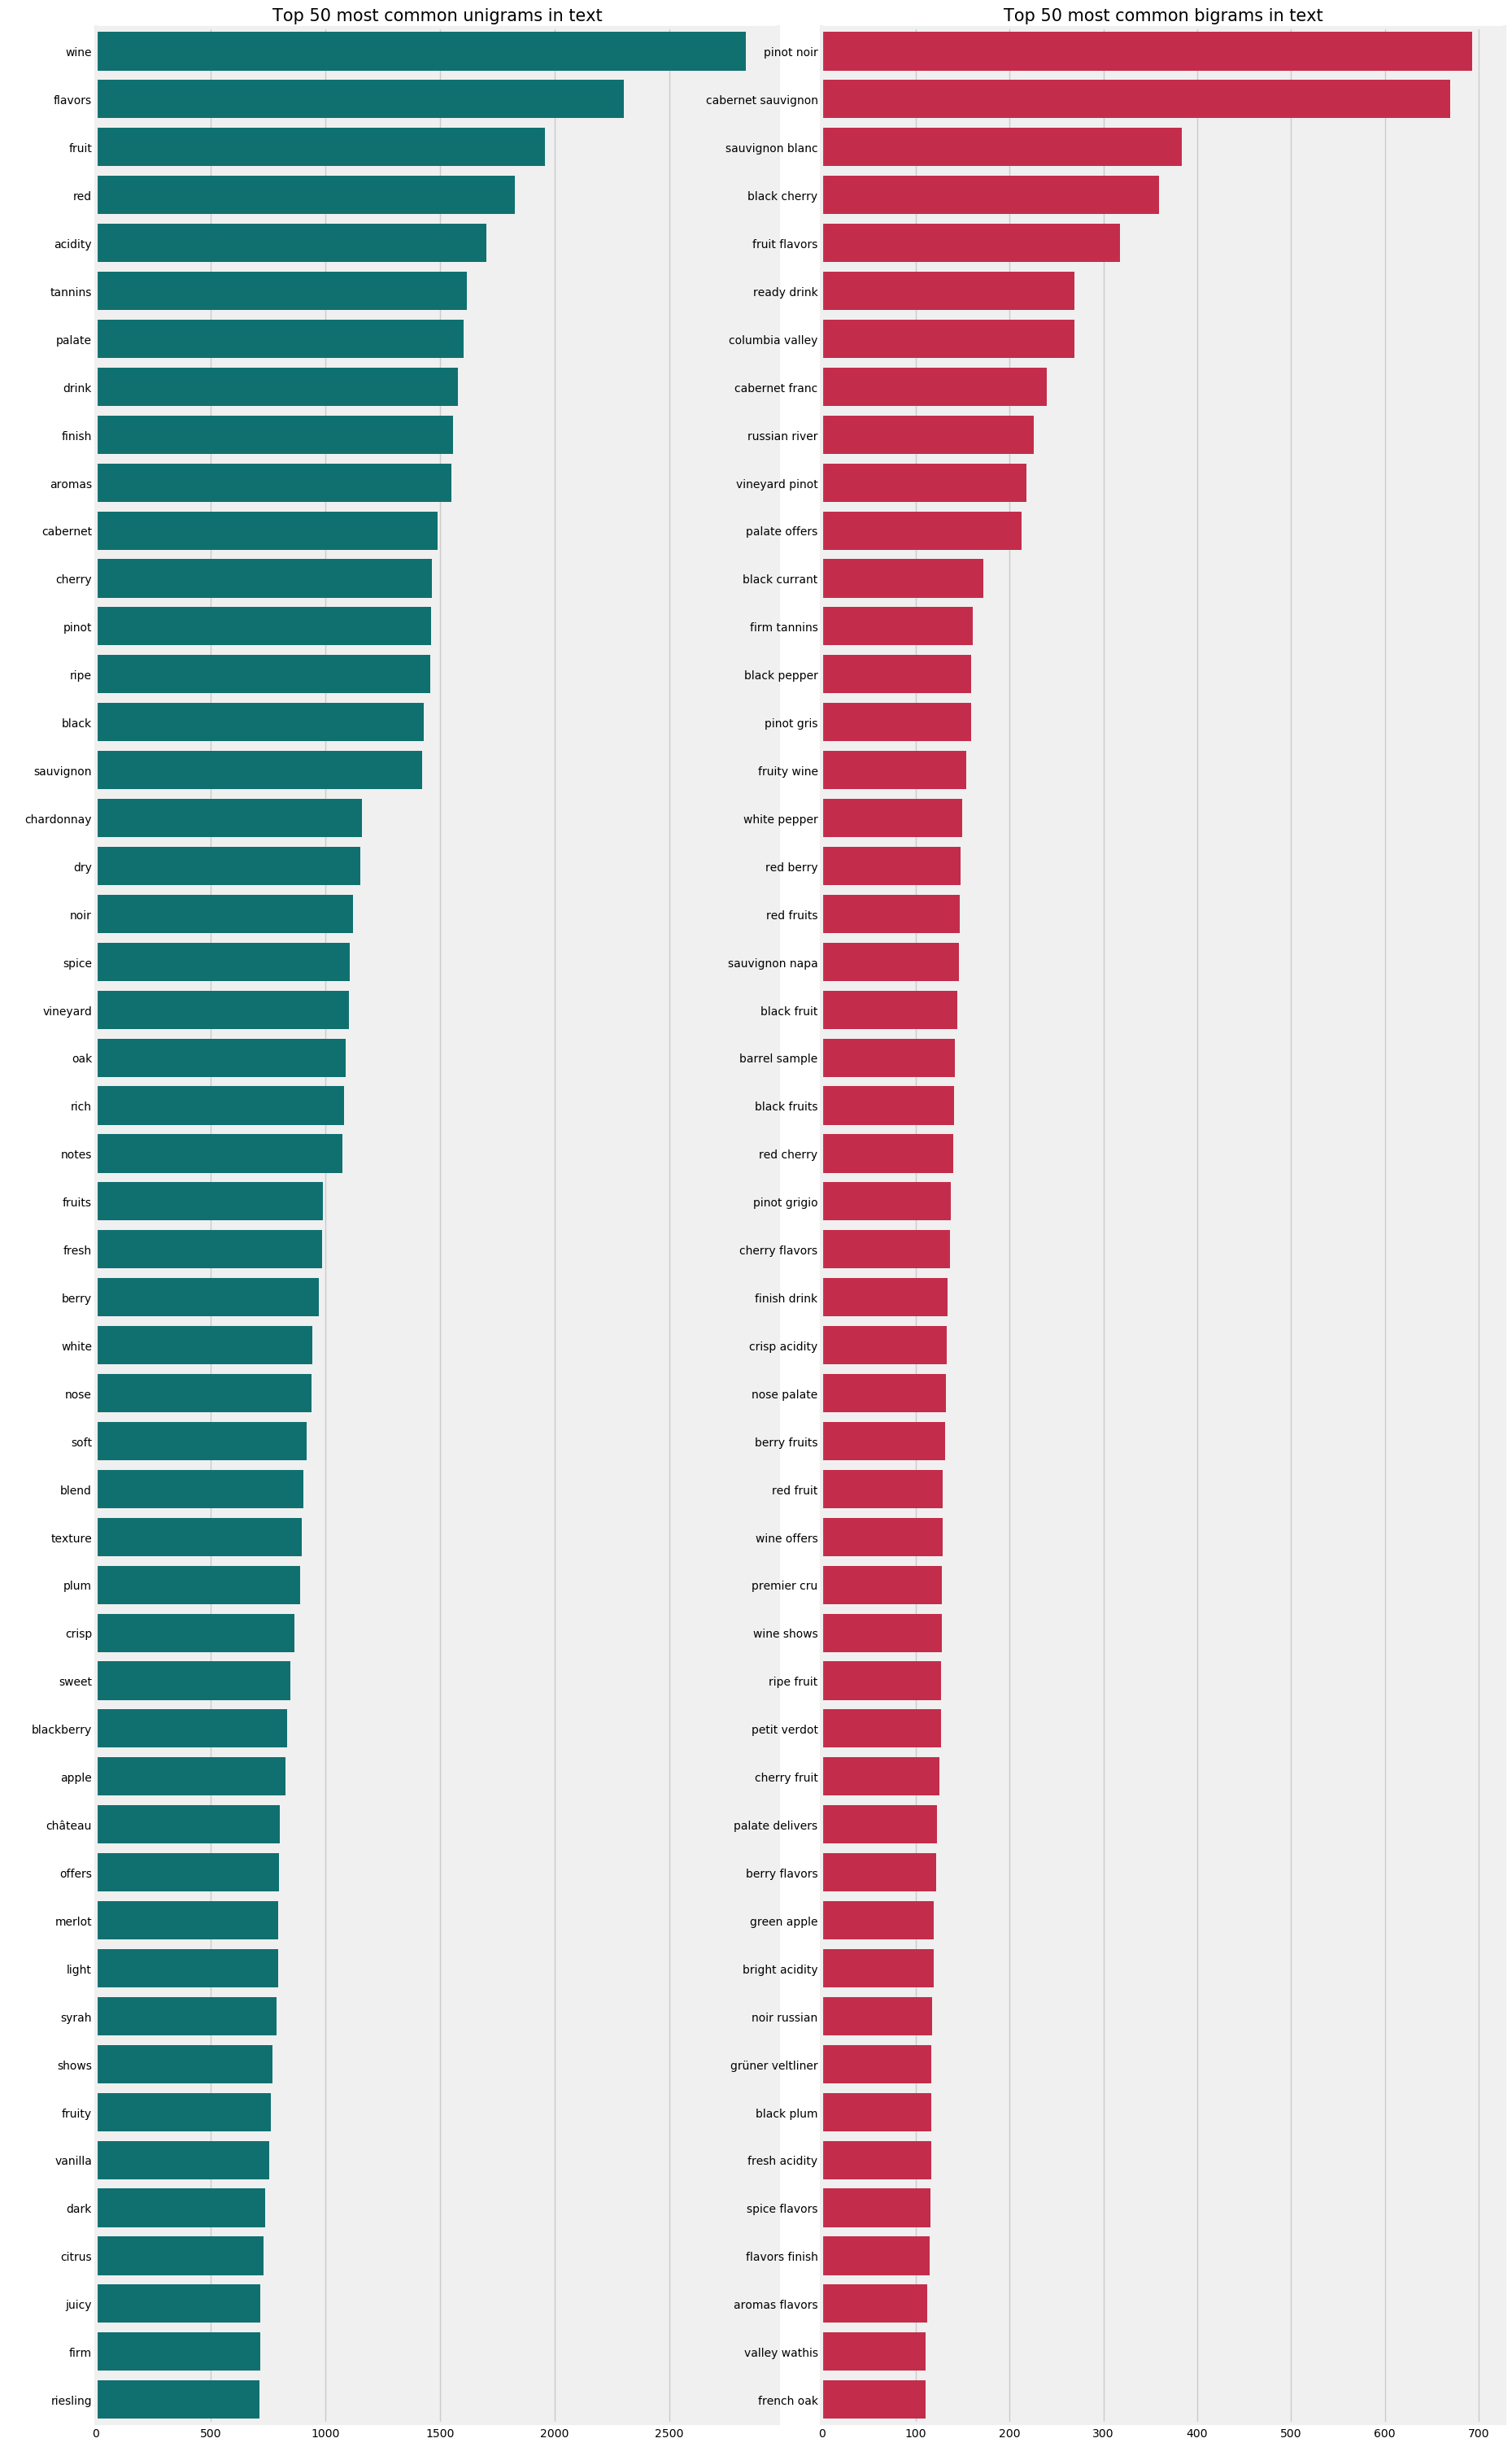

In [23]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_tweet_bigrams(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

top_unigrams=get_top_tweet_unigrams(train_text)[:50]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x, ax=axes[0], color='teal')


top_bigrams=get_top_tweet_bigrams(train_text)[:50]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x, ax=axes[1], color='crimson')


axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize=15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize=15)

plt.show()

In [24]:
%%time
# Get TF-IDF Vectorizer
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000)

word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

CPU times: user 34.4 s, sys: 479 ms, total: 34.9 s
Wall time: 34.9 s


In [25]:
# Convert Encoded Feature Into Spare Matrix
train_num_features = csr_matrix(train_df[['le_rating', 'price_log', 'le_country', 'le_province', 'le_winery']])
test_num_features = csr_matrix(test_df[['le_rating', 'price_log', 'le_country', 'le_province', 'le_winery']])

In [26]:
# Now stack TF-IDF Matrices to Encoded Feature Matrices 
train_features = hstack([train_word_features, 
                         train_num_features]).tocsr()

test_features = hstack([test_word_features, 
                        test_num_features]).tocsr()

In [27]:
# input of model
train_features

<82657x20005 sparse matrix of type '<class 'numpy.float64'>'
	with 3417230 stored elements in Compressed Sparse Row format>

In [28]:
test_features

<20665x20005 sparse matrix of type '<class 'numpy.float64'>'
	with 855164 stored elements in Compressed Sparse Row format>

# Building Model

### Random forest Implementation

In [29]:
# using random forest classifier
target = train_df['le_variety'].values

model = RandomForestClassifier(n_estimators=200, random_state=101, n_jobs=-1)

### K-Fold Cross Validation 

In [30]:
# Kfold Validation

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
f1_buf = []
cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(train_features, target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = train_features[train_ix], train_features[test_ix]
    train_y, test_y = target[train_ix], target[test_ix]
    
    # fiting the model
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    
    f1 = metrics.f1_score(test_y, preds, average='weighted')
    print('f1 score: {}'.format(f1))
    f1_buf.append(f1)
    cnt += 1

print('f1 mean score = {:.6f}'.format(np.mean(f1_buf)))
print('f1 std score = {:.6f}'.format(np.std(f1_buf)))

Fold 1
f1 score: 0.9375696568330989
Fold 2
f1 score: 0.9364815915120299
Fold 3
f1 score: 0.9335368637934771
Fold 4
f1 score: 0.9374836780881473
Fold 5
f1 score: 0.9352257986887598
f1 mean score = 0.936060
f1 std score = 0.001520


### Evalution Validation Set

In [31]:
# creating training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_features, target, test_size=0.2, random_state=42, stratify=target)

In [32]:
# Training
model.fit(X_train, y_train)
prediction = model.predict(X_valid)

In [33]:
# mean f1 score on validation set
f1_score = metrics.f1_score(y_valid, prediction, average='weighted')
print(' f1 score on validation set',f1_score)

# test error rate on validation set
test_error_rate = 1 - f1_score
print(' Test error rate on validation set',test_error_rate)

 f1 score on validation set 0.9381089453720446
 Test error rate on validation set 0.06189105462795541


It seems our model performing well, kfold cross-validation and validation dataset have same f1 score 0.93.

In [34]:
#classification report on validation set
print(classification_report(y_valid, prediction))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1099
           1       0.96      0.65      0.77       170
           2       0.94      0.91      0.93       219
           3       0.96      0.99      0.98      1510
           4       0.97      0.85      0.91       227
           5       0.93      0.99      0.96      1881
           6       0.99      0.85      0.91       163
           7       0.99      0.98      0.99       168
           8       1.00      1.00      1.00       211
           9       0.98      0.98      0.98       424
          10       0.99      0.89      0.94       494
          11       0.96      0.98      0.97       448
          12       0.98      1.00      0.99       175
          13       0.96      0.99      0.97       230
          14       0.97      0.98      0.98      2118
          15       0.95      0.98      0.97       394
          16       1.00      0.94      0.97       179
          17       0.79    

## Prediction & Submission

In [35]:
# prediction on test set
test_prediction = model.predict(test_features)

# converting predicted label into categorical variable
prediction_nonlabel = lbl.inverse_transform(test_prediction.astype(int))

# dataframe and submission
Pred_Label = pd.DataFrame(test_prediction, columns=['Pred_Label'])
Pred_Label.to_csv('Pred_LabelPrediction.csv', index = True)
Pred_Non_Label =  pd.DataFrame(prediction_nonlabel, columns=['Pred_Non_Label'])
Pred_Non_Label.to_csv('Pred_Non_LabelPrediction.csv', index = True)

In [36]:
Pred_Label.head(3)

,Pred_Label
0,14
1,9
2,5


In [37]:
Pred_Non_Label.head(3)

,Pred_Non_Label
0,Pinot Noir
1,Malbec
2,Chardonnay


In [38]:
test = pd.read_csv('../input/wine-variety/Data/test.csv')
final = pd.concat([test, Pred_Label, Pred_Non_Label], axis=1)

# submission
final.to_csv('TestPrediction.csv', index = True)

In [39]:
final.head(3)

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,Pred_Label,Pred_Non_Label
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars,14,Pinot Noir
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards,9,Malbec
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime,5,Chardonnay
